##  Data Science - Predição a Diabetes

In [2]:
# importando bibliotecas
import pandas as pd
import numpy as np
import os as so
from platform import python_version
import matplotlib.pyplot as plt
from sklearn import tree as tr
import gradio as gr
from sklearn.metrics import accuracy_score

print("Estou utilizando a versão Python:", python_version())

Estou utilizando a versão Python: 3.11.5


In [3]:
# Configurando diretório de trabalho

caminho = 'D:/data_science/projeto_diabetes'
so.chdir(caminho)


In [4]:
# Carregando dataset

df = pd.read_csv('diabetes.csv')
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# informações sobre os dados
df.info() # total de (768 linhas, 10 colunas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
# verificando valores vazios no dataset

df.isna().sum()

Gravidez               0
Glicose                0
Pressão Sanguínea      0
Espessura de Pele      0
Insulina               0
IMC                    0
Percentual Diabetes    0
Idade                  0
Resultado              0
dtype: int64

In [7]:
# renomeando colunas
df = df.rename(columns={'Pregnancies': 'Gravidez', 
                        'Glucose': 'Glicose', 
                        'BloodPressure': "Pressão Sanguínea",
                        'SkinThickness': "Espessura de Pele",
                        'Insulin':'Insulina',
                        'BMI': 'IMC',
                        'DiabetesPedigreeFunction': 'Percentual Diabetes',
                        'Age': 'Idade',
                        'Outcome':'Resultado'})
df.head(5)

,Gravidez,Glicose,Pressão Sanguínea,Espessura de Pele,Insulina,IMC,Percentual Diabetes,Idade,Resultado
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
# criando coluna condicional com tipo de Status de Predição
df['Status'] = df['Resultado'].apply(lambda Resultado: 'Negativo' if Resultado == 0 else 'Positivo')
df.head(3)

,Gravidez,Glicose,Pressão Sanguínea,Espessura de Pele,Insulina,IMC,Percentual Diabetes,Idade,Resultado,Status
0,6,148,72,35,0,33.6,0.627,50,1,Positivo
1,1,85,66,29,0,26.6,0.351,31,0,Negativo
2,8,183,64,0,0,23.3,0.672,32,1,Positivo


In [11]:
# explorando estatística básica de idades dos pacientes
df['Idade'].describe()

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Idade, dtype: float64

In [12]:
# proporção de pacientes com diabetes
dbt_positivo = df['Resultado'] == 1
pacientes_com_diabetes = df[dbt_positivo].value_counts().sum()
total_pacientes = df.value_counts().sum()
print("A proporção de pacientes com diabetes é de:",round((pacientes_com_diabetes/total_pacientes),2)*100,'%')

A proporção de pacientes com diabetes é de: 35.0 %


### Visualização dos Dados

<BarContainer object of 768 artists>

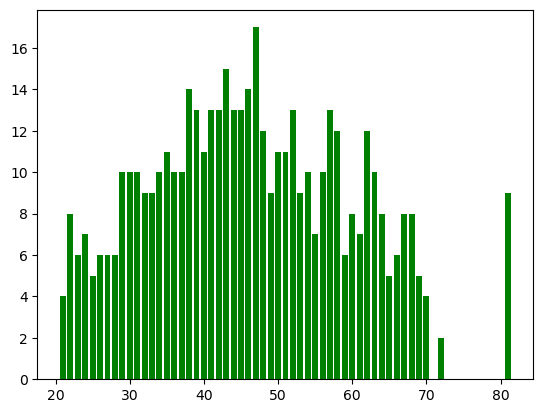

In [13]:
# Análise exploratória de gravidez por faixa de idade
plt.bar(df['Idade'], df['Gravidez'],width=0.8, color = 'green', label = "Idade")

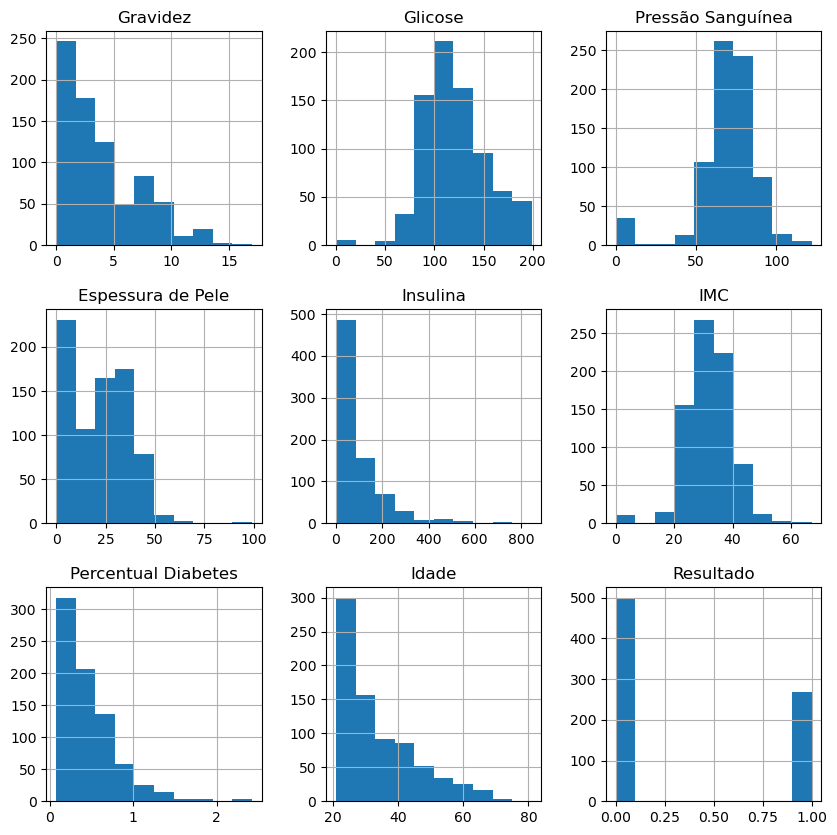

In [16]:
# Visualização geral em histograma

df.hist(figsize = (10,10))
plt.show()

In [17]:
# Desvio Padrão
df_estatistica = df.drop(columns = "Status")
df_estatistica.var()

Gravidez                  11.354056
Glicose                 1022.248314
Pressão Sanguínea        374.647271
Espessura de Pele        254.473245
Insulina               13281.180078
IMC                       62.159984
Percentual Diabetes        0.109779
Idade                    138.303046
Resultado                  0.227483
dtype: float64

###  Data Preprocessing

In [18]:
# tratamento de valores discrepantes

colunas_numericas = ['Insulina', 'Percentual Diabetes',]

for coluna in colunas_numericas:
    Q1 = np.percentile(df[coluna], 25, interpolation='midpoint')
    Q3 = np.percentile(df[coluna], 75, interpolation='midpoint')

    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR

    # encontrando discrepância na colunas específica
    outliers = df[(df[coluna] < low_lim) | (df[coluna] > up_lim)][coluna]

    # substituindo discrepâncias com os respectivos limites mínimos e maximos
    df[coluna] = np.where(df[coluna] < low_lim, low_lim, df[coluna])
    df[coluna] = np.where(df[coluna] > up_lim, up_lim, df[coluna])

C:\Users\feito\AppData\Local\Temp\ipykernel_16280\1112170701.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df[coluna], 25, interpolation='midpoint')
C:\Users\feito\AppData\Local\Temp\ipykernel_16280\1112170701.py:7: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(df[coluna], 75, interpolation='midpoint')


In [19]:
df[coluna]

0      0.627
1      0.351
2      0.672
3      0.167
4      1.201
       ...  
763    0.171
764    0.340
765    0.245
766    0.349
767    0.315
Name: Percentual Diabetes, Length: 768, dtype: float64

### Machine Learning

In [20]:
# dataset input
x_atributo = df.drop(columns = ['Status', 'Resultado']) 
x_atributo

,Gravidez,Glicose,Pressão Sanguínea,Espessura de Pele,Insulina,IMC,Percentual Diabetes,Idade
0,6,148,72,35,0.0,33.6,0.627,50
1,1,85,66,29,0.0,26.6,0.351,31
2,8,183,64,0,0.0,23.3,0.672,32
3,1,89,66,23,94.0,28.1,0.167,21
4,0,137,40,35,168.0,43.1,1.201,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.0,32.9,0.171,63
764,2,122,70,27,0.0,36.8,0.340,27
765,5,121,72,23,112.0,26.2,0.245,30
766,1,126,60,0,0.0,30.1,0.349,47


In [21]:
# dataset output
y_rotulo= df.loc[:, 'Resultado']
y_rotulo

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Resultado, Length: 768, dtype: int64

In [22]:
# excluindo dados para treinamento
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_atributo,y_rotulo, test_size = 0.20)

In [23]:
# definição do algoritmo
modelo = tr.DecisionTreeClassifier(max_depth = 3)

# treinamento do algoritmo
modelo_treinado = modelo.fit(X_train, y_train)

In [24]:
train_accuracy = modelo.score(X_train, y_train)
val_accuracy = modelo.score(X_test, y_test)
print('Acurácia do treinamento:',round(train_accuracy,2),"%")
print('Validação da acurácia:',round(val_accuracy,2),'%')

Acurácia do treinamento: 0.79 %
Validação da acurácia: 0.73 %


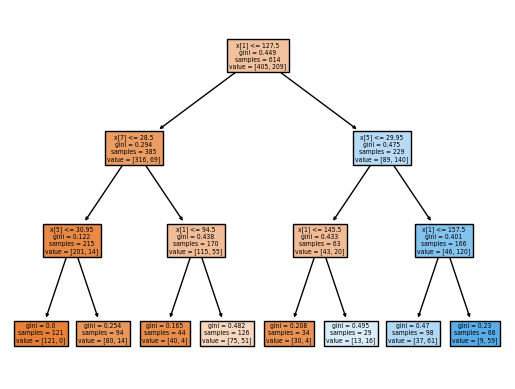

In [25]:
tr.plot_tree(modelo_treinado, filled = True);

In [37]:
# testando uma observação aleatória
x_novo = X_train.sample()
x_novo

,Gravidez,Glicose,Pressão Sanguínea,Espessura de Pele,Insulina,IMC,Percentual Diabetes,Idade
14,5,166,72,19,175.0,25.8,0.587,51


In [38]:
# probabilidade do paciente ter predisposição a diabetes
# (o resultado da probabilidade é em ordem alfabética)
previsao = modelo_treinado.predict_proba(x_novo)
previsao
print("Probabilidade do paciente ter diabetes - Negativo: {:.0f}% - Positivo: {:.0f}%".format(100*previsao[0][0],100*previsao[0][1]))

Probabilidade do paciente ter diabetes - Negativo: 45% - Positivo: 55%


### Apresentação do Projeto

In [ ]:
# recebendo as entradas do usuário e execução do algoritmo de previsão
def predict(*args):
    x_novo = np.array( [args]).reshape(1,-1)
    previsao = modelo_treinado.predict_proba(x_novo)
    
    return {"Negativo":previsao[0][0], "Positivo":previsao[0][1]}

with gr.Blocks(theme='freddyaboulton/dracula_revamped') as demo:
    #titulo do painel
    gr.Markdown( """ # Predição de Diabetes em Paciente""" )
    
    with gr.Row():
        with gr.Column():
            gr.Markdown( """ ## Característica do paciente """ )
            idade = gr.Slider(label = "Idade", minimum = 21, maximum = 81, step = 1, randomize = True)
            gravidez = gr.Slider(label = "Gravidez", minimum = 0, maximum = 17, step = 1, randomize = True)
            glicose = gr.Slider(label = "Glicose", minimum = 0, maximum = 199, step = 1, randomize = True)
            pressao = gr.Slider(label = "Pressão Sanguínea", minimum = 0, maximum = 122, step = 1, randomize = True)
            pele = gr.Slider(label = "Espessura da Pele", minimum = 0, maximum = 99, step = 1, randomize = True)
            insulina = gr.Slider(label = "Insulina", minimum = 0, maximum = 846, step = 1, randomize = True)
            imc = gr.Slider(label = "IMC", minimum = 0, maximum = 67.10, step = 1, randomize = True)
            diabetes = gr.Slider(label = "Percentual Diabetes", minimum = 0.078, maximum = 2.420, step = 0.01, randomize = True)
                    
             
            with gr.Row():
                gr.Markdown("""# """)
                predict_btn = gr.Button(value = "Predição")
                
        with gr.Column():
            gr.Markdown(""" ## Predição do Paciente desenvolver Diabetes""")
            label = gr.Label()
#botão predict
    predict_btn.click(
        fn=predict,
        inputs=[idade,
                gravidez,
                glicose,
                pressao,
                pele,
                insulina,
                imc,
                diabetes
        ], outputs = [label])
    
demo.launch(debug = True, share = False)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


C:\Users\feito\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\feito\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\feito\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\feito\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\feito\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\feito\anaconda3\Lib\site-packages\sklearn\base.py:4